<a href="https://colab.research.google.com/github/nagayahita/ml-data-science-portfolio/blob/main/car_predict_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px

In [ ]:
plt.style.use('ggplot')
sns.set_style("darkgrid")


In [ ]:
class CarPriceAnalysis:
    def __init__(self):
        self.train_data = None
        self.test_data = None
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}

        self.usd_rate = 1.1
        self.idr_rate = 15700

    def load_data(self, train_path, test_path):
        """
        Load both train and test datasets
        """
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path)

        print("=== INFORMASI DATASET ===")
        print(f"Jumlah data train: {len(self.train_data)}")
        print(f"Jumlah data test: {len(self.test_data)}")


        print("\nTipe data di train dataset:")
        print(self.train_data.dtypes)
        print("\nSample data train:")
        print(self.train_data.head())


        print("\nMissing values di train dataset:")
        print(self.train_data.isnull().sum())

        self._visualize_data_comparison()

    def _visualize_data_comparison(self):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(self.train_data['Price'], bins=50, label='Train')
        plt.title('Distribusi Harga Mobil (Train)')
        plt.xlabel('Harga')
        plt.ylabel('Frekuensi')

        plt.subplot(1, 2, 2)
        train_mfr = self.train_data['Manufacturer'].value_counts().head(10)
        test_mfr = self.test_data['Manufacturer'].value_counts().head(10)

        width = 0.35
        plt.bar(np.arange(len(train_mfr)), train_mfr.values, width, label='Train')
        plt.bar(np.arange(len(test_mfr)) + width, test_mfr.values, width, label='Test')
        plt.title('Top 10 Manufacturer (Train vs Test)')
        plt.xticks(np.arange(len(train_mfr)) + width/2, train_mfr.index, rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        try:
            numeric_cols = self.train_data.select_dtypes(include=[np.number]).columns
            categorical_cols = self.train_data.select_dtypes(include=['object']).columns

            for col in categorical_cols:
                if col in self.train_data.columns and col != 'Price':
                    le = LabelEncoder()
                    combined_data = pd.concat([
                        self.train_data[col],
                        self.test_data[col]
                    ]).unique()
                    le.fit(combined_data)

                    self.train_data[col] = le.transform(self.train_data[col])
                    self.test_data[col] = le.transform(self.test_data[col])
                    self.label_encoders[col] = le

            if self.train_data['Mileage'].dtype == 'object':
                self.train_data['Mileage'] = self.train_data['Mileage'].str.replace('km', '').astype(float)
            if self.test_data['Mileage'].dtype == 'object':
                self.test_data['Mileage'] = self.test_data['Mileage'].str.replace('km', '').astype(float)

            if 'Engine volume' in self.train_data.columns:
                if self.train_data['Engine volume'].dtype == 'object':
                    self.train_data['Engine volume'] = pd.to_numeric(
                        self.train_data['Engine volume'].str.replace('L', ''),
                        errors='coerce'
                    )
                if self.test_data['Engine volume'].dtype == 'object':
                    self.test_data['Engine volume'] = pd.to_numeric(
                        self.test_data['Engine volume'].str.replace('L', ''),
                        errors='coerce'
                    )

            print("\nPreprocessing selesai!")
            return self.train_data, self.test_data

        except Exception as e:
            print(f"Error dalam preprocessing: {str(e)}")
            print("\nInformasi data train:")
            print(self.train_data.dtypes)
            print("\nSample data Mileage train:")
            print(self.train_data['Mileage'].head())
            raise

    def train_model(self):
        X_train = self.train_data.drop(['Price', 'ID'], axis=1)
        y_train = self.train_data['Price']

        X_train_scaled = self.scaler.fit_transform(X_train)

        print("\n=== TRAINING MODEL ===")
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train_scaled, y_train)

        train_pred = self.model.predict(X_train_scaled)
        print("\nModel Performance pada data train:")
        print(f"R2 Score: {r2_score(y_train, train_pred):.4f}")
        print(f"RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.2f}")

        self._plot_feature_importance(X_train.columns)

    def _plot_feature_importance(self, feature_names):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance.head(10), x='importance', y='feature')
        plt.title('Top 10 Feature Paling Berpengaruh')
        plt.tight_layout()
        plt.show()

    def make_predictions(self, currency='USD'):
        """
        Make predictions and convert to specified currency
        currency: 'USD' or 'IDR'
        """
        if self.model is None:
            print("Error: Model belum ditraining!")
            return

        X_test = self.test_data.drop(['ID'], axis=1)
        X_test_scaled = self.scaler.transform(X_test)
        predictions = self.model.predict(X_test_scaled)


        if currency.upper() == 'USD':
            predictions_converted = predictions * self.usd_rate
            currency_symbol = '$'
            self.test_data['Predicted_Price_USD'] = predictions_converted
            formatted_predictions = [f"${price:,.2f}" for price in predictions_converted]
            self.test_data['Formatted_Price'] = formatted_predictions
            print("\nHarga dalam USD")
        else:
            predictions_converted = predictions * self.usd_rate * self.idr_rate
            self.test_data['Predicted_Price_IDR'] = predictions_converted
            formatted_predictions = [f"Rp {int(price):,}" for price in predictions_converted]
            self.test_data['Formatted_Price'] = formatted_predictions
            print("\nHarga dalam Rupiah")

        print("\n=== SAMPLE PREDICTIONS ===")
        print(self.test_data[['ID', 'Manufacturer', 'Model', 'Formatted_Price']].head())

        self._visualize_predictions(predictions_converted, currency)

        return self.test_data

    def _visualize_predictions(self, predictions, currency):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(predictions, bins=50)
        plt.title(f'Distribusi Harga Prediksi ({currency})')
        plt.xlabel('Harga')
        plt.ylabel('Frekuensi')

        plt.subplot(1, 2, 2)
        plt.scatter(self.test_data['Prod. year'], predictions, alpha=0.5)
        plt.title(f'Prediksi Harga vs Tahun Produksi ({currency})')
        plt.xlabel('Tahun Produksi')
        plt.ylabel(f'Harga Prediksi ({currency})')
        plt.tight_layout()
        plt.show()


=== INFORMASI DATASET ===
Jumlah data train: 19237
Jumlah data test: 8245

Tipe data di train dataset:
ID                    int64
Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

Sample data train:
         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Je

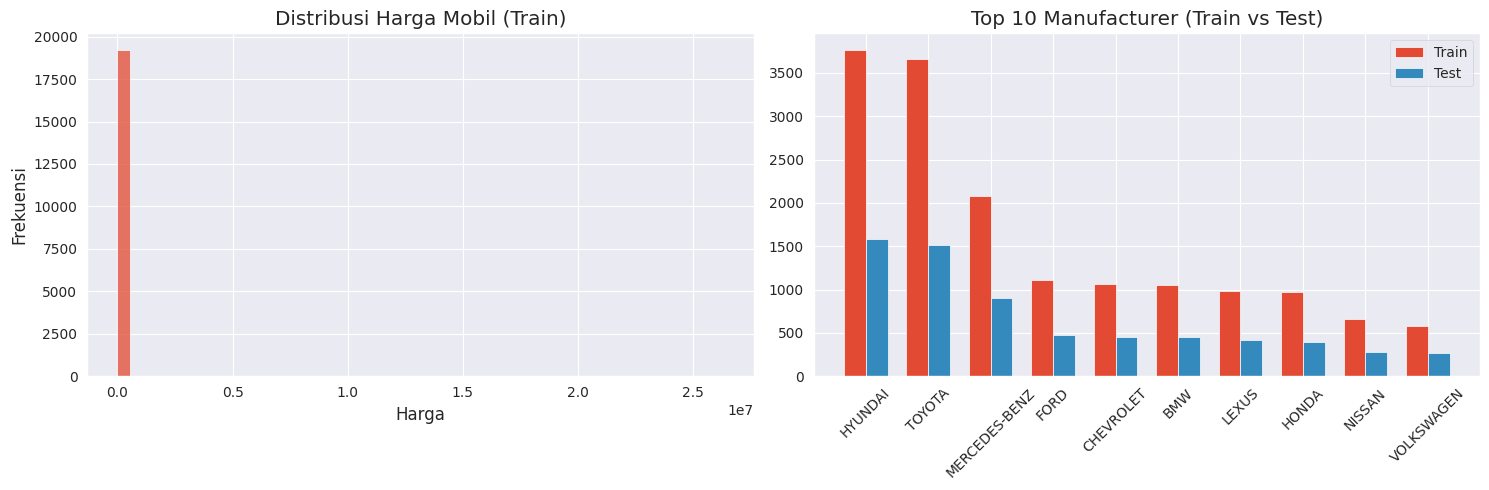


Preprocessing selesai!

=== TRAINING MODEL ===

Model Performance pada data train:
R2 Score: 0.7541
RMSE: 94506.96


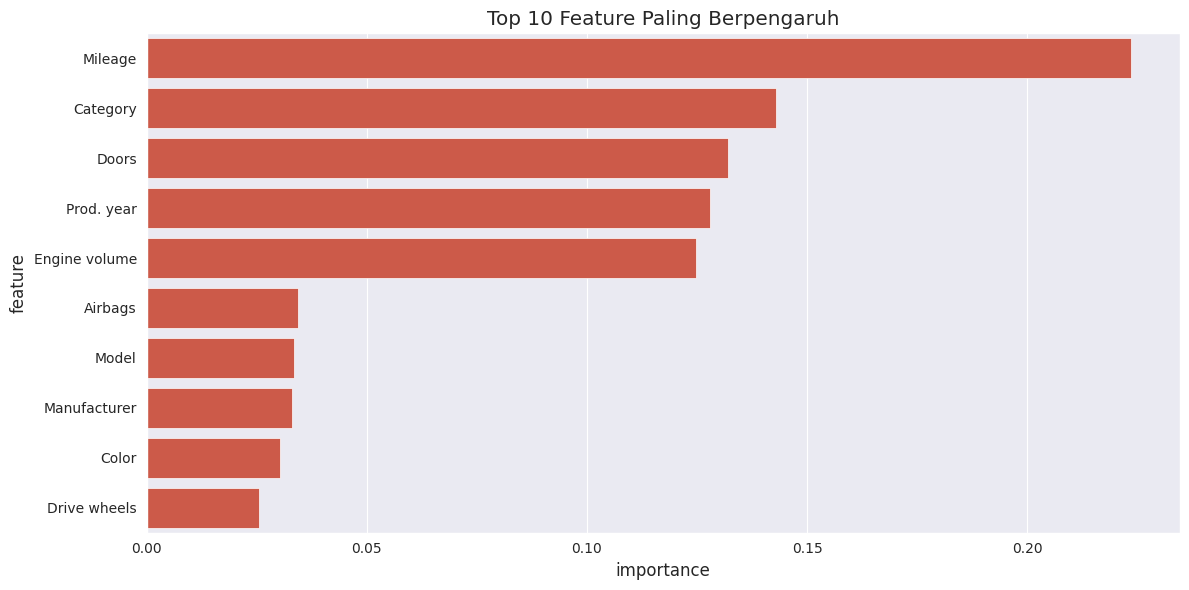


Error: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Price


Silakan cek format data dan tipe data pada kolom-kolom dataset


In [ ]:
if __name__ == "__main__":
    try:

        analyzer = CarPriceAnalysis()


        analyzer.load_data('train.csv', 'test.csv')

        train_processed, test_processed = analyzer.preprocess_data()


        analyzer.train_model()


        predictions_usd = analyzer.make_predictions(currency='USD')


        predictions_idr = analyzer.make_predictions(currency='IDR')


        predictions_usd[['ID', 'Formatted_Price']].to_csv('predictions_usd.csv', index=False)
        predictions_idr[['ID', 'Formatted_Price']].to_csv('predictions_idr.csv', index=False)
        print("\nPrediksi telah disimpan ke CSV")

    except Exception as e:
        print(f"\nError: {str(e)}")
        print("\nSilakan cek format data dan tipe data pada kolom-kolom dataset")